### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
import glob
from datetime import datetime
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import skimage.transform
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from model import *
import cv2

In [27]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 1.14.0


In [28]:
K.set_image_data_format('channels_first')

In [29]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [30]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

C:\Users\Rosana\Documents\Mestrado\dissertacao\unet\scripts\model.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [31]:
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

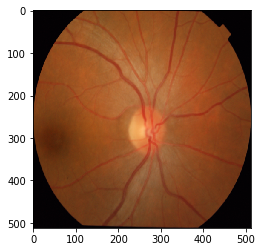

(50, 512, 512, 3)


In [32]:
plt.imshow(img_train[45])
plt.show()
print(img_train.shape)

In [33]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [44]:
green_channel_train = []
for i in (img_train):
    green = np.zeros(i.shape)
    green[:,:,0] = i[:,:,1]
    green_channel_train.append(green)

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

In [45]:
gen = data_generator(green_channel_train, cup_train, disc_locations, 128, 'train', batch_size=1)
batch = next(gen)

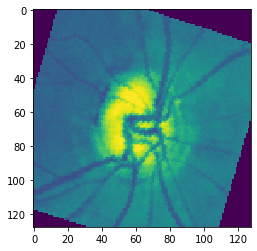

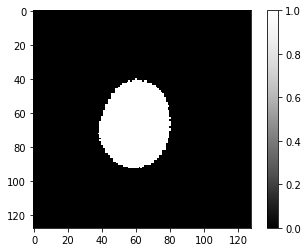

In [46]:
plt.imshow(batch[0][0][0])
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [23]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))
print(weights_folder)

C:\Users\Rosana\Documents\Mestrado\dissertacao\original\optic-nerve-cnn\models_weights\OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss


In [24]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [ ]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

In [ ]:
green_channel_test = []
for i in (img_test):
    green = np.zeros(i.shape)
    green[:,:,0] = i[:,:,1]
    green_channel_test.append(green)

In [25]:
X_valid, Y_valid = next(data_generator(green_channel_test, cup_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(green_channel_train, cup_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                              
                              validation_data=(X_valid, Y_valid),
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_green.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_green.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/500
99/99 [==============================] - 454s 5s/step - loss: 0.8373 - mean_IOU_gpu: 0.0692 - dice_metric: 0.1292 - val_loss: 0.8026 - val_mean_IOU_gpu: 3.1023e-04 - val_dice_metric: 6.1948e-04
Epoch 2/500
99/99 [==============================] - 509s 5s/step - loss: 0.8029 - mean_IOU_gpu: 0.1061 - dice_metric: 0.1908 - val_loss: 0.8004 - val_mean_IOU_gpu: 0.0056 - val_dice_metric: 0.0111
Epoch 3/500
99/99 [==============================] - 512s 5s/step - loss: 0.8044 - mean_IOU_gpu: 0.1473 - dice_metric: 0.2546 - val_loss: 0.7982 - val_mean_IOU_gpu: 0.3194 - val_dice_metric: 0.4752
Epoch 4/500
99/99 [==============================] - 498s 5s/step - loss: 0.8006 - mean_IOU_gpu: 0.1886 - dice_metric: 0.3137 - val_loss: 0.7953 - val_mean_IOU_gpu: 0.4347 - val_dice_metric: 0.5974
Epoch 5/500
99/99 [==============================] - 495s 5s/step - loss: 0.8189 - mean_IOU_gpu: 0.2143 - dice_metric: 0.3474 - val_loss: 0.7918 - val_mean_IOU_gpu: 0.4448 - val_dice_metric: 0.6071
Ep

Epoch 81/500
99/99 [==============================] - 580s 6s/step - loss: 0.1552 - mean_IOU_gpu: 0.7209 - dice_metric: 0.8276 - val_loss: 3.7099 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 82/500
99/99 [==============================] - 581s 6s/step - loss: 0.1562 - mean_IOU_gpu: 0.7153 - dice_metric: 0.8254 - val_loss: 3.6824 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 83/500
99/99 [==============================] - 568s 6s/step - loss: 0.1532 - mean_IOU_gpu: 0.7247 - dice_metric: 0.8298 - val_loss: 3.6320 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 84/500
99/99 [==============================] - 527s 5s/step - loss: 0.1523 - mean_IOU_gpu: 0.7261 - dice_metric: 0.8308 - val_loss: 3.7449 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00


### Visual check

In [ ]:
pred_iou, pred_dice = [], []
pred_cup = []
for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = green_channel_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_cup.append(pred)
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Training and Test disc

In [ ]:
X_valid, Z_valid = next(data_generator(green_channel_test, disc_test, disc_locations_test, train_or_test='test', batch_size=100, stationary=True))

In [ ]:
history = model.fit_generator(data_generator(green_channel_train, disc_train, disc_locations, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Z_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_green.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_green.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

In [ ]:
pred_iou, pred_dice = [], []
pred_disc = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = green_channel_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_z = Z_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_disc.append(pred)
    corr = th_to_tf_encoding(batch_z)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

In [ ]:
def ellipseFitting(img):
    contours, hierarchy = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    ellipse = np.zeros(img.shape)
    diametro = []
    for ind, cont in enumerate(contours):
        (x,y),(MA,ma),angle = cv2.fitEllipse(cont)
        diametro.append((MA, ma))
        cv2.ellipse(ellipse,(int(x),int(y)),(int(MA/2), int(ma/2)),angle,0,360,(255,255,255),0)
    return ellipse, diametro

In [ ]:
cdrs = []
for i, img_no in enumerate(test_idx):
    cup = pred_cup[i]
    disc = pred_disc[i]
        
    c = cv2.Canny(cup.astype(np.uint8), 1,1)
    d = cv2.Canny(disc.astype(np.uint8), 1,1)
    
    el_c, diam_c = ellipseFitting(c)
    el_d, diam_d = ellipseFitting(d)
        
    if len(diam_d) > 0 and len(diam_c) > 0:
        cdrs.append(diam_c[0][1]/diam_d[0][1])
cdrs